In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import scipy
import skimage
import tensorflow as tf
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './dataset/notmnist' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./dataset/notmnist/notMNIST_large.tar.gz
Found and verified ./dataset/notmnist/notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders  = maybe_extract(test_filename)

./dataset/notmnist/notMNIST_large already present - Skipping extraction of ./dataset/notmnist/notMNIST_large.tar.gz.
['./dataset/notmnist/notMNIST_large/A', './dataset/notmnist/notMNIST_large/B', './dataset/notmnist/notMNIST_large/C', './dataset/notmnist/notMNIST_large/D', './dataset/notmnist/notMNIST_large/E', './dataset/notmnist/notMNIST_large/F', './dataset/notmnist/notMNIST_large/G', './dataset/notmnist/notMNIST_large/H', './dataset/notmnist/notMNIST_large/I', './dataset/notmnist/notMNIST_large/J']
./dataset/notmnist/notMNIST_small already present - Skipping extraction of ./dataset/notmnist/notMNIST_small.tar.gz.
['./dataset/notmnist/notMNIST_small/A', './dataset/notmnist/notMNIST_small/B', './dataset/notmnist/notMNIST_small/C', './dataset/notmnist/notMNIST_small/D', './dataset/notmnist/notMNIST_small/E', './dataset/notmnist/notMNIST_small/F', './dataset/notmnist/notMNIST_small/G', './dataset/notmnist/notMNIST_small/H', './dataset/notmnist/notMNIST_small/I', './dataset/notmnist/not

In [4]:
import random

# Visualise a sample of each label
def display_images(filename, samples_per_label):
    print ('Displaying images in: ', filename)
    folder = os.path.join(data_root, filename)
    for label in sorted(os.listdir(folder)):
        if(label.endswith('.pickle') == False):
            print ('Label: ', label)
            label_folder = os.path.join(folder, label)
            dirs = os.listdir(label_folder)
            random.shuffle(dirs)
            for image in dirs[:samples_per_label]:
                display(Image(filename=os.path.join(label_folder, image), width=20.0, height=20.0))
            
display_images('notMNIST_large', 5)
display_images('notMNIST_small', 5)

Displaying images in:  notMNIST_large
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


Displaying images in:  notMNIST_small
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


In [5]:
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./dataset/notmnist/notMNIST_large/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/C.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/D.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/E.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/F.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/G.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/H.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/I.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/J.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/C.pick

Displaying pickles from train dataset


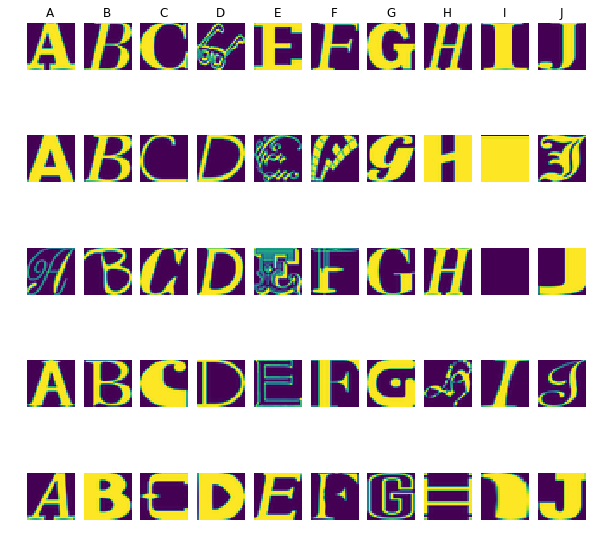

Displaying pickles from test dataset


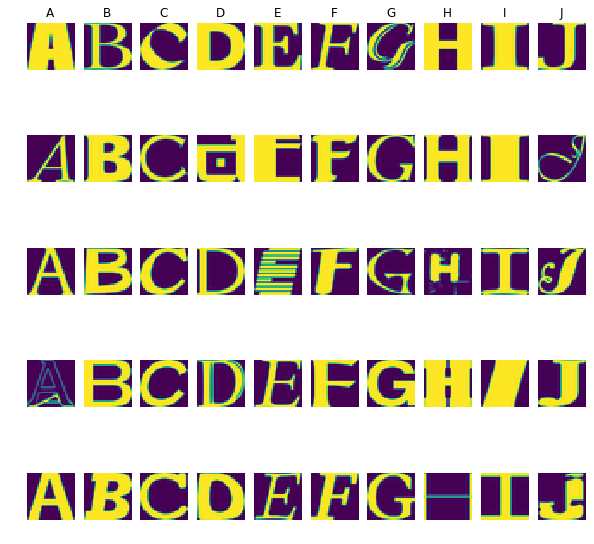

In [7]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_labels = len(labels)

def display_pickle(dataset, samples_per_label):
    for y, label in enumerate(labels):
        pickles = pickle.load(open(dataset[y], 'rb'))
        idxs = np.random.choice(pickles.shape[0], samples_per_label, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_labels + y + 1
            plt.subplot(samples_per_label, num_labels, plt_idx)
            plt.imshow(pickles[idx, :, :])
            plt.axis('off')
            if i == 0:
                plt.title(label)
    plt.show()
    

print ('Displaying pickles from train dataset')
display_pickle(train_datasets, 5)
print ('Displaying pickles from test dataset')
display_pickle(test_datasets, 5)

In [8]:
img_size = image_size
new_size = (28, 56)

def make_arrays(nb_rows, size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, size[0], size[1]), dtype=np.float32)
        labels = np.ndarray((nb_rows, 5), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, dataset_size):
    dataset, labels = make_arrays(dataset_size, new_size)
    pickles = []
    for i in range(10):
        pickles.append(pickle.load(open(pickle_files[i], 'rb')))

    for i in range(dataset_size):
        # Generate a random label with max length 5 chars
        data_length  = np.random.choice(5, 1)[0] + 1
#         data_length = 5
        random_chars = np.random.choice(10, data_length)
#         random_chars = np.random.choice(9, data_length)
        data_label   = np.append(random_chars, np.full(5 - data_length, 10, dtype=int))
        
        chars = []
        
        for char in random_chars:
            index = np.random.choice(len(pickles[char]), 1)
            chars.append(np.reshape(pickles[char][index, :, :], (img_size, img_size)))

        image = np.ndarray((img_size, data_length * img_size))
        
        for idx, char in enumerate(chars):
            image[:, img_size*idx:img_size*(idx+1)] = char

        image = skimage.transform.resize(image, new_size)

        dataset[i] = image
        labels[i]  = data_label
    return (dataset, labels)

if not os.path.exists(os.path.join(data_root, 'train_no_length.pickle')):
    train = merge_datasets(train_datasets, 200000)
    saveAsPickle(train, os.path.join(data_root, 'train_no_length.pickle'))
else:
    print('Train dataset already exists')
    train = loadPickle(os.path.join(data_root, 'train_no_length.pickle'))
if not os.path.exists(os.path.join(data_root, 'valid_no_length.pickle')):
    valid = merge_datasets(train_datasets, 5000)
    saveAsPickle(valid, os.path.join(data_root, 'valid_no_length.pickle'))
else:
    print('Validation dataset already exists')
    valid = loadPickle(os.path.join(data_root, 'valid_no_length.pickle'))
if not os.path.exists(os.path.join(data_root, 'test_no_length.pickle')):
    test  = merge_datasets(test_datasets, 10000)
    saveAsPickle(test, os.path.join(data_root, 'test_no_length.pickle'))
else:
    print('Test dataset already exists')
    test  = loadPickle(os.path.join(data_root, 'test_no_length.pickle'))

Train dataset already exists
Validation dataset already exists
Test dataset already exists


In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train[0], train[1])
test_dataset, test_labels = randomize(test[0], test[1])
valid_dataset, valid_labels = randomize(valid[0], valid[1])

Displaying training images
[[5 8 6 3 6]
 [8 5 3 4 1]
 [6 8 0 0 6]]


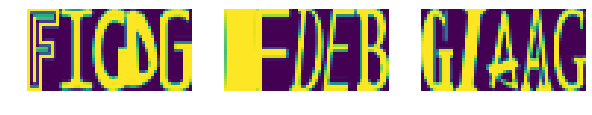

Displaying test images
[[1 8 5 2 5]
 [0 0 7 0 1]
 [0 4 1 6 7]]


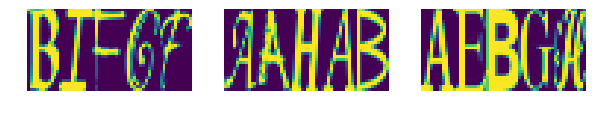

Displaying validation images
[[0 5 4 0 0]
 [5 4 2 0 6]
 [2 8 6 2 8]]


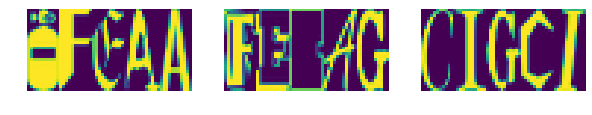

In [10]:
def display_dataset(dataset, labels, samples_per_label):
    idxs = np.random.choice(dataset.shape[0], samples_per_label, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i + 1
        plt.subplot(1, samples_per_label, plt_idx)
        plt.imshow(dataset[idx])
        plt.axis('off')
    print(labels[idxs])
    plt.show()
    
print ('Displaying training images')
display_dataset(train_dataset, train_labels, 3)
print ('Displaying test images')
display_dataset(test_dataset, test_labels, 3)
print ('Displaying validation images')
display_dataset(valid_dataset, valid_labels, 3)

In [11]:
new_size = (28, 56)
num_labels = 11
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, new_size[0], new_size[1], num_channels)).astype(np.float32)
    labels = np.eye(11)[labels]
    
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 56, 1) (200000, 5, 11)
Validation set (5000, 28, 56, 1) (5000, 5, 11)
Test set (10000, 28, 56, 1) (10000, 5, 11)


## Network

In [12]:
def accuracy(predictions, labels):
    predictions = np.transpose(predictions, (1, 0, 2))
    global_acc = 100.0 * np.mean(np.prod(np.argmax(predictions, 2) == np.argmax(labels, 2), 1))
    individual_acc = 100 *np.mean(np.argmax(predictions,2) == np.argmax(labels, 2), 0)
    return [global_acc, individual_acc]

In [27]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64
image_size = (28, 56)
num_outputs = 5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_dataset = tf.placeholder(tf.float32, shape=(None, image_size[0], image_size[1], num_channels), name='data')
    tf_labels  = tf.placeholder(tf.float32, shape=(None, num_outputs, num_labels), name='labels')
    tf_learning_rate = tf.placeholder(tf.float32, name='learning_rate')
  
    # Variables.
    ## First convolutional layer
    with tf.name_scope('conv1/'):
        conv1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth], stddev=0.1), name='conv1_w')
        conv1_biases  = tf.Variable(tf.zeros(shape=[depth]), name='conv1_b')
    
    ## Second convolutional layer
    with tf.name_scope('conv2/'):
        conv2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.1), name='conv2_w')
        conv2_biases  = tf.Variable(tf.constant(1.0, shape=[depth]), name='conv2_b')
    
    ## fully connected layer
    with tf.name_scope('fc1/'):
        fc1_weights = tf.Variable(tf.truncated_normal(
            [image_size[0] // 4 * image_size[1] // 4 * depth, num_hidden], stddev=0.1), name='fc1_w')
        fc1_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name= 'fc1_b')
                                
    with tf.name_scope('fc2/'):
        fc2_weights = tf.Variable(tf.truncated_normal(
            [num_hidden, num_hidden], stddev=0.1), name='fc2_w')
        fc2_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name= 'fc2_b')
    
    ## softmax
    with tf.name_scope('digit1/'):
        softmax1_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name='digit1_w')
        softmax1_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='digit1_b')
    
    with tf.name_scope('digit2/'):
        softmax2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name='digit2_w')
        softmax2_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='digit2_b')
    
    with tf.name_scope('digit3/'):
        softmax3_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name='digit3_w')
        softmax3_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='digit3_b')
    
    with tf.name_scope('digit4/'):
        softmax4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name='digit4_w')
        softmax4_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='digit4_b')
    
    with tf.name_scope('digit5/'):
        softmax5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name='digit5_w')
        softmax5_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='digit5_b')
  
    # Model.
    def model(data):
        # first conv
        with tf.name_scope('conv1/'):
            conv   = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
            conv   = tf.nn.relu(conv + conv1_biases)
            hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # second conv
        with tf.name_scope('conv2/'):
            conv   = tf.nn.conv2d(hidden, conv2_weights, [1, 1, 1, 1], padding='SAME')
            conv   = tf.nn.relu(conv + conv2_biases)
            hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # flatten
        with tf.name_scope('flatten/'):
            shape   = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])
        
        # fc1
        with tf.name_scope('fc1/'):
            hidden  = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        # fc2
        with tf.name_scope('fc2/'):
            hidden = tf.nn.relu(tf.matmul(hidden, fc2_weights) + fc2_biases)
        
        # classifiers
        with tf.name_scope('digit1/'):
            classifier1 = tf.matmul(hidden, softmax1_weights) + softmax1_biases
        with tf.name_scope('digit2/'):
            classifier2 = tf.matmul(hidden, softmax2_weights) + softmax2_biases
        with tf.name_scope('digit3/'):
            classifier3 = tf.matmul(hidden, softmax3_weights) + softmax3_biases
        with tf.name_scope('digit4/'):
            classifier4 = tf.matmul(hidden, softmax4_weights) + softmax4_biases
        with tf.name_scope('digit5/'):
            classifier5 = tf.matmul(hidden, softmax5_weights) + softmax5_biases
        
        return [classifier1, classifier2, classifier3, classifier4, classifier5]
  
    # Training computation.
    logits = model(tf_dataset)
    
    total_loss = 0
    for i in range(len(logits)):
        with tf.name_scope(f'digit{i+1}/'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=tf_labels[:, i], logits=logits[i]))
            tf.summary.scalar(f'loss{i+1}', loss)
            total_loss += loss
    tf.summary.scalar('total_loss', total_loss)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(tf_learning_rate)
    grads_and_vars = optimizer.compute_gradients(total_loss)
    minimize = optimizer.minimize(total_loss)
    
    # Gradient norm summary
    for g,v in grads_and_vars:
        if 'fc2_w' in v.name:
            with tf.name_scope('gradients'):
                tf_last_grad_norm = tf.sqrt(tf.reduce_mean(g**2))
                tf.summary.scalar('grad_norm', tf_last_grad_norm)
                break
  
    merged = tf.summary.merge_all()
    # Predictions
    def prediction(logits):
        prediction = []
        for i in range(len(logits)):
            with tf.name_scope(f'prediction{i+1}'):
                prediction.append(tf.nn.softmax(logits[i]))
        return tf.stack(prediction)
    
    predictions = prediction(logits)


In [28]:
def printStatistics(dataset ,loss, accuracies):
    print(f'\t{dataset} loss: {loss}')
    print(f'\t{dataset} accuracy: {accuracies[0]:.2f}%')
    for i in range(len(accuracies[1])):
        print(f'\tDigit{i}: {accuracies[1][i]:.2f}%')
            

In [ ]:
num_steps = 7001

with tf.Session(graph=graph) as session:
    if not os.path.exists('summaries'):
        os.mkdir('summaries')
    writer = tf.summary.FileWriter('summaries', session.graph)
    
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_dataset: batch_data, tf_labels: batch_labels, tf_learning_rate: 0.05}
        _, t_loss, t_predictions, summary = session.run(
            [minimize, total_loss, predictions, merged], feed_dict=feed_dict)
        if (step % 10 ==0):
            writer.add_summary(summary, step)
            if (step % 100 == 0):
                print(f'step {step}:')
                t_accuracies = accuracy(t_predictions, batch_labels)
                printStatistics('Train', t_loss, t_accuracies)

                # Validation
                feed_dict = {tf_dataset: valid_dataset, tf_labels: valid_labels}
                v_loss, v_predictions = session.run([total_loss, predictions], feed_dict=feed_dict)
                v_accuracies = accuracy(v_predictions, valid_labels)
                printStatistics('Validation', v_loss, v_accuracies)
            
    # Test
    feed_dict = {tf_dataset: test_dataset, tf_labels: test_labels}
    test_loss, test_predictions = session.run([total_loss, predictions], feed_dict=feed_dict)
    test_accuracies = accuracy(test_predictions, test_labels)
    printStatistics('Test', test_loss, test_accuracies)

Initialized
step 0:
	Train loss: 16.47400665283203
	Train accuracy: 0.00%
	Digit0: 12.50%
	Digit1: 0.00%
	Digit2: 3.12%
	Digit3: 6.25%
	Digit4: 0.00%
	Validation loss: 24.695037841796875
	Validation accuracy: 0.00%
	Digit0: 11.88%
	Digit1: 11.62%
	Digit2: 10.48%
	Digit3: 11.72%
	Digit4: 11.16%
step 100:
	Train loss: 11.07287883758545
	Train accuracy: 0.00%
	Digit0: 9.38%
	Digit1: 12.50%
	Digit2: 12.50%
	Digit3: 15.62%
	Digit4: 21.88%
	Validation loss: 11.081823348999023
	Validation accuracy: 0.00%
	Digit0: 11.48%
	Digit1: 12.04%
	Digit2: 11.50%
	Digit3: 11.70%
	Digit4: 11.32%
step 200:
	Train loss: 10.447803497314453
	Train accuracy: 3.12%
	Digit0: 31.25%
	Digit1: 12.50%
	Digit2: 18.75%
	Digit3: 15.62%
	Digit4: 25.00%
	Validation loss: 10.572127342224121
	Validation accuracy: 0.00%
	Digit0: 20.54%
	Digit1: 17.28%
	Digit2: 18.34%
	Digit3: 19.30%
	Digit4: 21.66%
step 300:
	Train loss: 9.515077590942383
	Train accuracy: 0.00%
	Digit0: 18.75%
	Digit1: 31.25%
	Digit2: 43.75%
	Digit3: 28.12%

	Validation loss: 2.9598324298858643
	Validation accuracy: 38.34%
	Digit0: 83.68%
	Digit1: 82.30%
	Digit2: 83.82%
	Digit3: 83.92%
	Digit4: 80.68%
step 2900:
	Train loss: 2.9569292068481445
	Train accuracy: 34.38%
	Digit0: 87.50%
	Digit1: 90.62%
	Digit2: 81.25%
	Digit3: 81.25%
	Digit4: 71.88%
	Validation loss: 2.94423246383667
	Validation accuracy: 37.40%
	Digit0: 83.28%
	Digit1: 83.30%
	Digit2: 81.74%
	Digit3: 83.84%
	Digit4: 81.30%
step 3000:
	Train loss: 2.271864891052246
	Train accuracy: 37.50%
	Digit0: 90.62%
	Digit1: 87.50%
	Digit2: 75.00%
	Digit3: 84.38%
	Digit4: 84.38%
	Validation loss: 2.8642914295196533
	Validation accuracy: 38.86%
	Digit0: 83.18%
	Digit1: 81.60%
	Digit2: 83.38%
	Digit3: 83.90%
	Digit4: 84.04%
step 3100:
	Train loss: 2.028778076171875
	Train accuracy: 59.38%
	Digit0: 90.62%
	Digit1: 84.38%
	Digit2: 96.88%
	Digit3: 90.62%
	Digit4: 90.62%
	Validation loss: 2.897639036178589
	Validation accuracy: 38.14%
	Digit0: 83.62%
	Digit1: 81.62%
	Digit2: 83.26%
	Digit3: 83.

step 5700:
	Train loss: 3.531794548034668
	Train accuracy: 34.38%
	Digit0: 84.38%
	Digit1: 84.38%
	Digit2: 87.50%
	Digit3: 87.50%
	Digit4: 78.12%
	Validation loss: 2.533970832824707
	Validation accuracy: 44.46%
	Digit0: 85.70%
	Digit1: 84.86%
	Digit2: 85.30%
	Digit3: 85.60%
	Digit4: 85.40%
step 5800:
	Train loss: 1.735201120376587
	Train accuracy: 75.00%
	Digit0: 93.75%
	Digit1: 87.50%
	Digit2: 96.88%
	Digit3: 96.88%
	Digit4: 96.88%
	Validation loss: 2.56758189201355
	Validation accuracy: 44.36%
	Digit0: 84.88%
	Digit1: 84.34%
	Digit2: 85.86%
	Digit3: 85.30%
	Digit4: 85.88%
step 5900:
	Train loss: 2.8645753860473633
	Train accuracy: 37.50%
	Digit0: 87.50%
	Digit1: 90.62%
	Digit2: 78.12%
	Digit3: 78.12%
	Digit4: 84.38%
	Validation loss: 2.5232362747192383
	Validation accuracy: 44.76%
	Digit0: 84.80%
	Digit1: 85.82%
	Digit2: 85.86%
	Digit3: 84.94%
	Digit4: 85.58%
step 6000:
	Train loss: 1.4960745573043823
	Train accuracy: 68.75%
	Digit0: 84.38%
	Digit1: 96.88%
	Digit2: 96.88%
	Digit3: 87